In [14]:

#Rader data
data = {'f': [0, 0, 0, 0, 0, 0, 0, 0, 16, 15, 15, 15, 15, 15, 16, 16, 15, 14, 14, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 14, 
14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 15, 16, 15, 16, 16, 17, 17, 18, 18, 18, 18, 18, 17, 18, 18, 18, 18, 18, 18, 17], 'b': [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 23, 23, 23, 22, 23, 23, 23, 23, 23, 24, 29, 24, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 24, 29, 29, 29, 23, 23, 23, 23, 23, 24, 25, 29, 26, 29, 29, 29, 0, 0, 64, 65, 65, 64, 64, 
63, 62, 0, 0, 0, 0, 65, 90, 77, 76, 76, 76, 75, 88, 65, 89, 89, 89, 71, 70, 70, 70, 71, 68, 71, 70, 69, 64, 68, 69, 69, 67, 69, 67, 66, 67]}
#f is data ranging from 40 degrees to 140 degrees
#b is data ranging from 220 degrees to 320 degrees

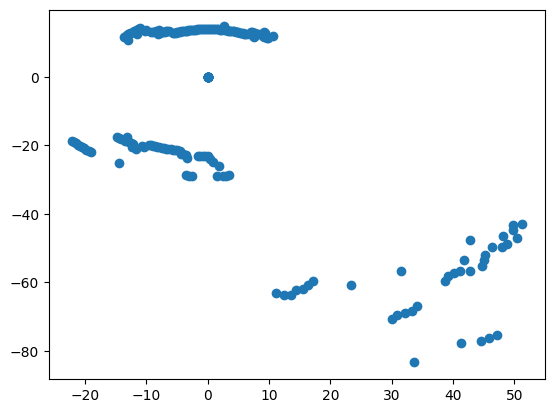

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Constants
FOV_DEGREES = 101
NUM_READINGS = 101
CELL_SIZE = 5

# Initialize an empty occupancy grid map
map_width = 50
map_height = 50
occupancy_grid = np.zeros((map_height, map_width))

#! Front - 40 to 140 --------------------------------------------------
front = np.array(data['f'])

angles = np.linspace(np.deg2rad(40), np.deg2rad(140), NUM_READINGS)

front_x_coords = front * np.cos(angles)
front_y_coords = front * np.sin(angles)


#! Back - 220 to 320 --------------------------------------------------
back = np.array(data['b'])

angles = np.linspace(np.deg2rad(220), np.deg2rad(320), NUM_READINGS)

back_x_coords = back * np.cos(angles)
back_y_coords = back * np.sin(angles)

#! Plotting --------------------------------------------------
#concat
x_coords = np.concatenate((front_x_coords, back_x_coords))
y_coords = np.concatenate((front_y_coords, back_y_coords))

#plot front
plt.figure()
plt.scatter(x_coords, y_coords)
plt.show()

Sample sensor readings and grid indices:


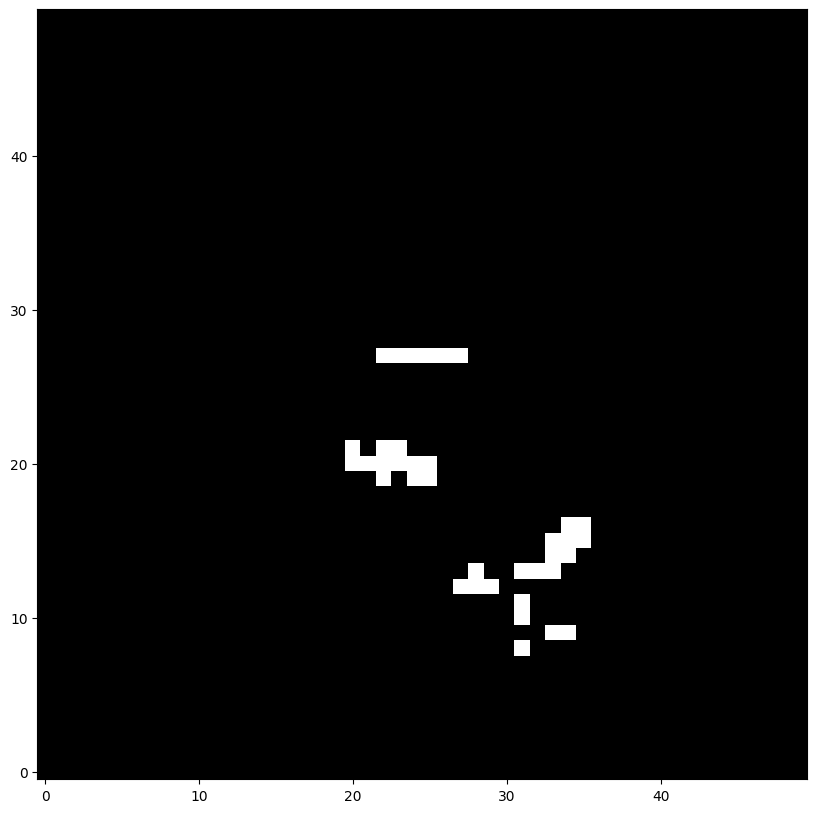

"# Normalize the occupancy grid to 0-255 for proper grayscale display\noccupancy_grid_normalized = cv2.normalize(occupancy_grid, None, 0, 255, cv2.NORM_MINMAX)\n# Convert to uint8 type for imshow\noccupancy_grid_normalized = np.uint8(occupancy_grid_normalized)\n# Flip the occupancy grid vertically\noccupancy_grid_flipped = cv2.flip(occupancy_grid_normalized, 0)\n\n# Display the occupancy grid map\ncv2.imshow('Occupancy Grid Map', occupancy_grid_flipped)\ncv2.waitKey(0)  # Wait indefinitely for a key press\ncv2.destroyAllWindows()  # Close the window after a key press"

In [9]:
# Debugging: Print the first few sensor readings and their grid indices
print("Sample sensor readings and grid indices:")
for i, (x, y) in enumerate(zip(x_coords, y_coords)):

    grid_x = int(x // CELL_SIZE + map_width / 2)
    grid_y = int(y // CELL_SIZE + map_height / 2)

    if x == 0 and y == 0:
        continue

    if 0 <= grid_x < map_width and 0 <= grid_y < map_height:

        #print grid indices
        #print(f"({grid_x}, {grid_y})")
        occupancy_grid[grid_y, grid_x] = 1  # Mark as occupied

#convert occupancy_grid to integer
occupancy_grid = occupancy_grid.astype(int)

# Plot the occupancy grid map
plt.figure(figsize=(10, 10), dpi=100)  
plt.imshow(occupancy_grid, cmap='gray', origin='lower')
plt.show()

'''# Normalize the occupancy grid to 0-255 for proper grayscale display
occupancy_grid_normalized = cv2.normalize(occupancy_grid, None, 0, 255, cv2.NORM_MINMAX)
# Convert to uint8 type for imshow
occupancy_grid_normalized = np.uint8(occupancy_grid_normalized)
# Flip the occupancy grid vertically
occupancy_grid_flipped = cv2.flip(occupancy_grid_normalized, 0)

# Display the occupancy grid map
cv2.imshow('Occupancy Grid Map', occupancy_grid_flipped)
cv2.waitKey(0)  # Wait indefinitely for a key press
cv2.destroyAllWindows()  # Close the window after a key press'''

# Particle Filter

In [4]:
from plotter import plot
import numpy as np

data1 = {'f': [0, 0, 0, 0, 0, 0, 0, 0, 16, 15, 15, 15, 15, 15, 16, 16, 15, 14, 14, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 14, 
14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 15, 16, 15, 16, 16, 17, 17, 18, 18, 18, 18, 18, 17, 18, 18, 18, 18, 18, 18, 17], 'b': [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 23, 23, 23, 22, 23, 23, 23, 23, 23, 24, 29, 24, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 24, 29, 29, 29, 23, 23, 23, 23, 23, 24, 25, 29, 26, 29, 29, 29, 0, 0, 64, 65, 65, 64, 64, 
63, 62, 0, 0, 0, 0, 65, 90, 77, 76, 76, 76, 75, 88, 65, 89, 89, 89, 71, 70, 70, 70, 71, 68, 71, 70, 69, 64, 68, 69, 69, 67, 69, 67, 66, 67]}

data2 = {'f': [0, 0, 0, 0, 25, 23, 16, 16, 16, 15, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 
14, 14, 14, 14, 14, 14, 13, 14, 13, 14, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 15, 15, 16, 15, 16, 
16, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 18, 17], 'b': [49, 38, 49, 38, 29, 29, 29, 24, 24, 24, 29, 29, 29, 29, 24, 24, 23, 23, 23, 23, 23, 23, 23, 30, 29, 29, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 23, 23, 23, 24, 25, 29, 29, 23, 23, 23, 23, 23, 24, 24, 24, 25, 29, 29, 24, 24, 24, 24, 29, 29, 29, 25, 29, 29, 29, 29, 29, 29, 29, 91, 89, 89, 89, 89, 89, 88, 89, 78, 80, 78, 89, 80, 72, 72, 72, 77, 77, 77, 76, 77, 70, 71, 71, 70, 70, 70, 70, 70, 77, 76]}

data1 = plot(data1, 40, 140, 220, 320, 101)
data2 = plot(data2, 40, 140, 220, 320, 101)

#to numpy array
data1 = np.array(list(data1))
data2 = np.array(list(data2))

In [5]:
from particle_filter_manual import icp

#T = icp(data1, data2, 1000, 0)
T = [[ 0.99797225, -0.06365053,  5.05972548],
 [ 0.06365053,  0.99797225, -1.36986665],
 [ 0.       ,   0.      ,    1.        ]]

#sample transformation of robot pose (at origin)
x = 0
y = 0
theta = 0

robot_pose = np.array([
    [np.cos(theta), -np.sin(theta), x],
    [np.sin(theta),  np.cos(theta), y],
    [0,              0,             1]
])

#apply transformation
new_robot_pose = np.dot(T, robot_pose)

print(new_robot_pose)

#turn into angle (x, y, theta)
x = new_robot_pose[0, 2]
y = new_robot_pose[1, 2]
theta = np.arctan2(new_robot_pose[1, 0], new_robot_pose[0, 0])

print(x, y, theta)

[[ 0.99797225 -0.06365053  5.05972548]
 [ 0.06365053  0.99797225 -1.36986665]
 [ 0.          0.          1.        ]]
5.05972548 -1.36986665 0.06369358734298614


In [6]:
#Simple test
pose = np.array([0, 0, 1])
pose.dot(T.T)

AttributeError: 'list' object has no attribute 'T'

In [ ]:
x = [13,4,20,25,55,68]
y = [15,6,22,27,57,70] 

fix_error = 2
front_offset = 2.54
back_offset = 2.54

In [ ]:
import cv2
import numpy
import random
import matplotlib.pyplot
from particle_filter import icp as quick_icp
import numpy as np

n1 = 100
n2 = 75
bruit = 1/10
center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
radius = random.random()
deformation = 2

template = numpy.array([
    [numpy.cos(i*2*numpy.pi/n1)*radius*deformation for i in range(n1)], 
    [numpy.sin(i*2*numpy.pi/n1)*radius for i in range(n1)]
])

data = numpy.array([
    [numpy.cos(i*2*numpy.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
    [numpy.sin(i*2*numpy.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
])

a = list(zip(list(template[0]), list(template[1])))
a = np.array(a)

# Convert to homogeneous coordinates
a_homogeneous = np.hstack((a, np.ones((a.shape[0], 1))))

#sample T
T = [[ 0.99797225, -0.06365053,  5.05972548],
 [ 0.06365053,  0.99797225, -1.36986665],
 [ 0.       ,   0.      ,    1.        ]]

# Apply transformation
b = np.dot(T, a_homogeneous.T).T
b